In [6]:

import pandas as pd
import pulp
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict


In [7]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)

In [8]:
preferential_information = [(5,1),
                    (1,3),
                    (3,11),
                    (11,14),
                    (14,22),
                    (22,24),
                    (24,27)]

indifference_information = [(3, 7),
                            (22, 23)]

In [9]:
from uta import solve_lp_problem
problem, u_vars, criteria, breakpoints = solve_lp_problem(df, preferential_information, indifference_information)


Status: Optimal
epsilon = 0.0625
u1(0.32) = 0.125
u1(0.34) = 0.125
u1(0.35) = 0.125
u1(0.4) = 0.125
u1(0.44) = 0.125
u1(0.45) = 0.125
u1(0.48) = 0.125
u1(0.59) = 0.125
u1(0.6) = 0.125
u1(0.61) = 0.125
u1(0.62) = 0.125
u1(0.64) = 0.0625
u1(0.65) = 0.0625
u1(0.66) = 0.0625
u1(0.68) = 0.0625
u1(0.69) = 0.0625
u1(0.71) = 0.0625
u1(0.73) = 0.0625
u1(0.74) = 0.0
u1(0.76) = 0.0
u1(0.78) = 0.0
u1(0.8) = 0.0
u1(0.83) = 0.0
u1(0.87) = 0.0
u1(1.0) = 0.0
u2(0.03) = 0.1875
u2(0.06) = 0.1875
u2(0.22) = 0.1875
u2(0.24) = 0.1875
u2(0.25) = 0.1875
u2(0.27) = 0.1875
u2(0.3) = 0.1875
u2(0.4) = 0.1875
u2(0.44) = 0.1875
u2(0.45) = 0.1875
u2(0.49) = 0.0
u2(0.54) = 0.0
u2(0.55) = 0.0
u2(0.83) = 0.0
u2(0.86) = 0.0
u2(0.87) = 0.0
u2(0.9) = 0.0
u2(0.91) = 0.0
u2(0.93) = 0.0
u2(0.95) = 0.0
u2(0.97) = 0.0
u2(1.0) = 0.0
u3(0.0) = 0.4375
u3(0.38) = 0.3125
u3(0.45) = 0.3125
u3(0.54) = 0.3125
u3(0.56) = 0.3125
u3(0.57) = 0.3125
u3(0.65) = 0.0
u3(0.7) = 0.0
u3(0.71) = 0.0
u3(0.8) = 0.0
u3(0.81) = 0.0
u3(0.88) = 0.0
u3

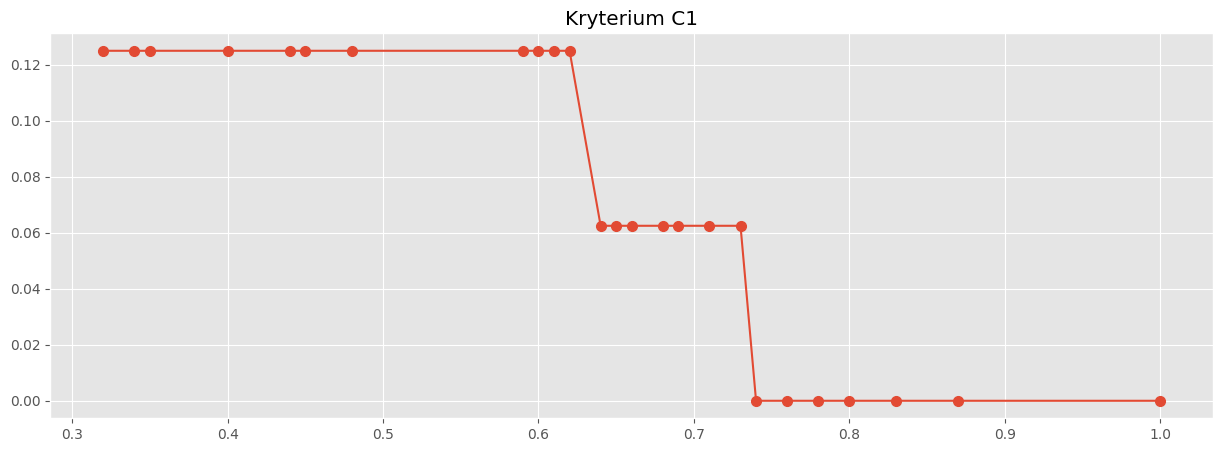

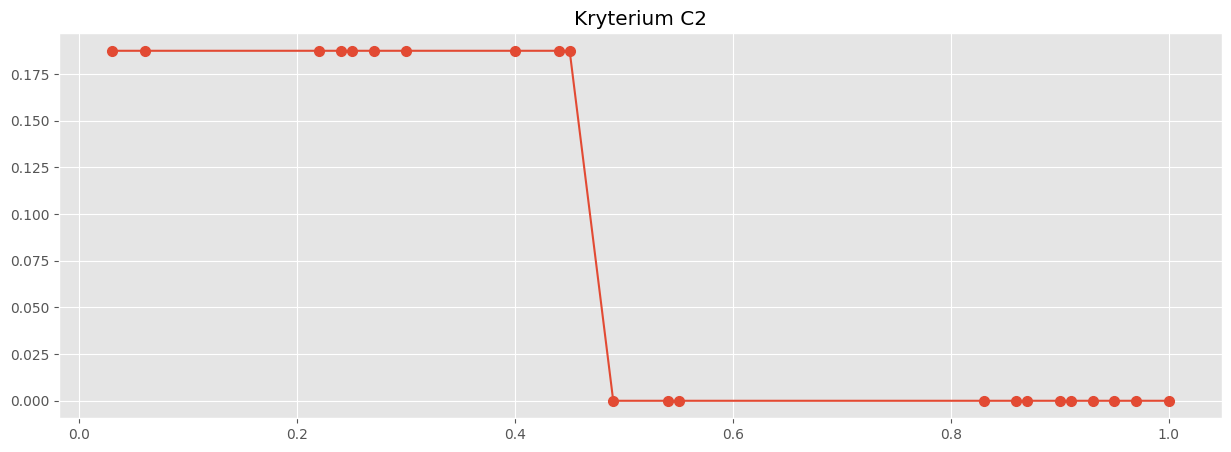

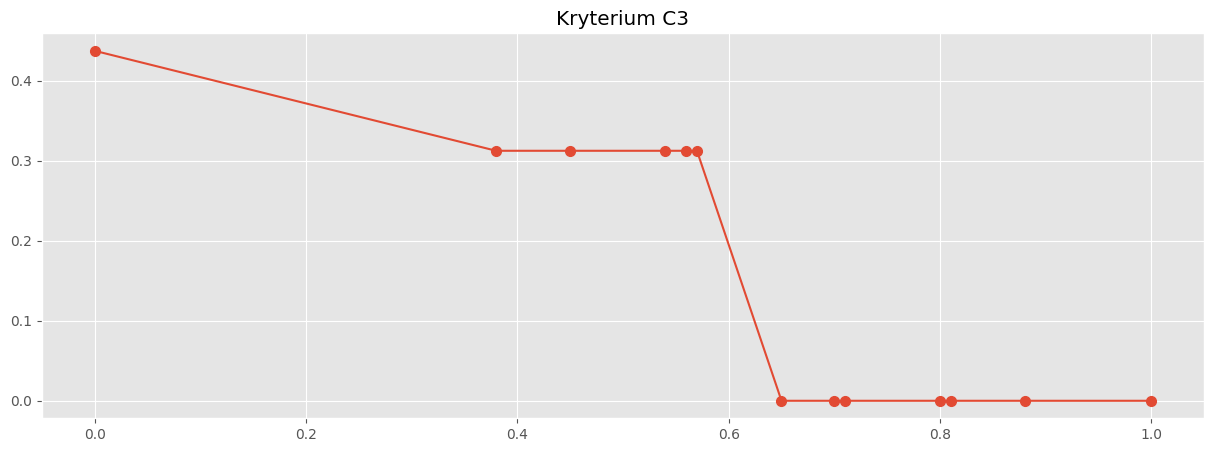

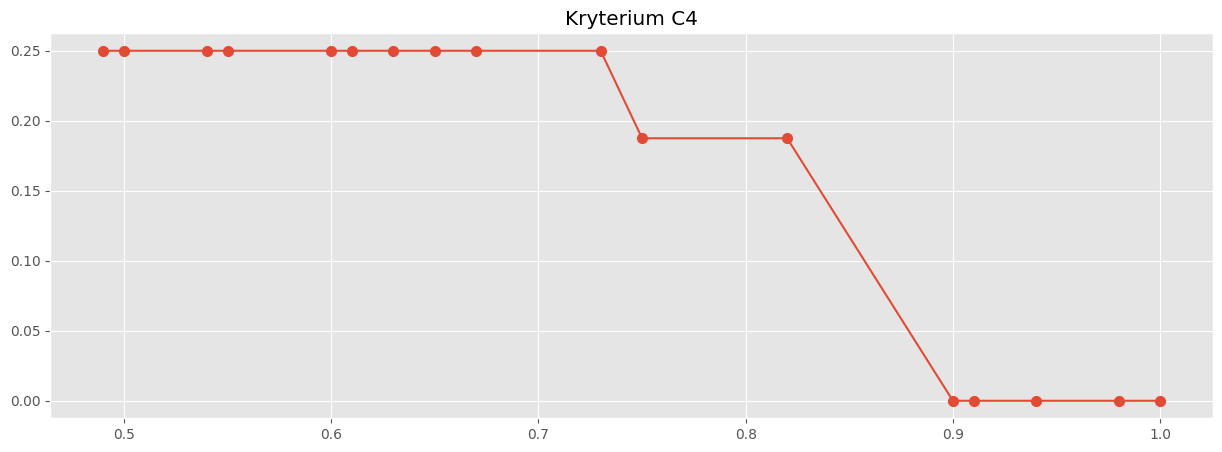

In [10]:
from uta import plot_utility_functions
plot_utility_functions(problem, u_vars, criteria)

In [11]:
from uta import create_full_ranking_df

rank = create_full_ranking_df(df, problem, criteria)

In [12]:
rank.sort_values(by=['U'], ascending=False)

,C1,C2,C3,C4,u1,u2,u3,u4,U
5,0.62,0.40,0.56,0.50,0.125,0.1875,0.3125,0.25,0.875
1,0.60,0.93,0.00,0.73,0.125,0.0,0.4375,0.25,0.8125
10,0.45,0.86,0.00,0.73,0.125,0.0,0.4375,0.25,0.8125
8,0.64,0.44,0.54,0.54,0.0625,0.1875,0.3125,0.25,0.8125
3,1.00,0.45,0.57,0.50,0.0,0.1875,0.3125,0.25,0.75
4,0.48,0.87,0.00,0.75,0.125,0.0,0.4375,0.1875,0.75
7,0.40,0.90,0.00,0.82,0.125,0.0,0.4375,0.1875,0.75
11,0.61,0.54,0.38,0.49,0.125,0.0,0.3125,0.25,0.6875
2,0.66,0.55,0.45,0.49,0.0625,0.0,0.3125,0.25,0.625
14,0.69,0.49,0.56,0.61,0.0625,0.0,0.3125,0.25,0.625


In [13]:
from uta import check_consistency
check_consistency(rank, preferential_information, indifference_information)

True